# Create plots for panels used in figure S2

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# folder to save all panels for figure S2
savefolder = r"plots\SI\fig_S2"

In [3]:
#define a color seed for each patient
color_dict = {'VS': 'C0', 'VL': 'C1', 'RS': 'C2',
              'KM': 'C3', 'LM': 'C4'}
color_seeds_dict = {'VS': 'Blues', 'VL': 'Oranges', 'RS': 'Greens',
                    'LM': 'Purples', 'KM': 'Reds'}

In [4]:
patient_labels = {'VS': 'P1', 'VL': 'P2', 'RS': 'P3', 'LM': 'P4', 'KM': 'P5'}

def deformed_probability_curve(df, v_min=0, v_max=3, binsize=.25):
    """Compute the values for the shape probability diagram to find a cell
    in a deformed state for velocities between v_min and v_max in the DataFrame df

    returns: *tuple* (deformed_bins, deformed_hist_normal)
        - deformed_bins: *array* limits for the bin ranges of the histogram
        - normalized counts for each velocity range
    """

    bins = int(v_max/binsize)   #number of Bins in histogram
    #find index of cells in a deformed state. Class definitions are:
    #1-parachute, 2-slipper, 3-asym. parachute, 5-multilobe, 7-undefined deformed
    #4-discocyte/undeformed, 6-tumbler
    deformed_index = ((df['shape'] == 1)
                      | (df['shape'] == 2)
                      | (df['shape'] == 3)
                      | (df['shape'] == 5)
                      | (df['shape'] == 7))

    #create new column in df that is True for deformed state
    df['deformed'] = False
    df['deformed'][deformed_index] = True

    df_deformed = df[deformed_index]

    deformed_hist, deformed_bins = np.histogram(np.array(df_deformed['velocity']),
                                                range = (v_min,v_max),
                                                bins = bins)
    #get the counts for all events to use for normalization
    all_hist, all_bins = np.histogram(np.array(df['velocity']),
                                      range = (v_min,v_max),
                                      bins = bins)

    #normalize the deformed histogram
    deformed_hist_normal = deformed_hist/all_hist

    return deformed_bins, deformed_hist_normal

def plot_all_shape_analysis_curves(patient):
    result_summary_folder = r"data\shape_analysis\result_summaries"

    patient = patient
    patient_label = patient_labels[patient]

    v_min = 0.
    v_max = 3.
    binsize = 0.25

    result_file = os.path.join(result_summary_folder, patient + "_results_MCFM.tsv")
    df_results = pd.read_csv(result_file, sep='\t')

    dates = np.unique(df_results['date'])
    dates = np.sort(dates)

    color = color_dict[patient]
    color_seed = color_seeds_dict[patient]
    colors = sns.color_palette(color_seed, n_colors=len(dates))

    day0 = pd.to_datetime(dates[0])

    with plt.style.context('dark_background'):
        for num, date in enumerate(dates):
            df_date = df_results[df_results['date']==date]
            #create new Dataframe to work with, leave out skipped cells
            df = df_date[df_date['shape'] != 0]

            healthy_index = df['health'] == 0
            df_healthy = df[healthy_index]
            unhealthy_index = df['health'] == 1
            df_unhealthy = df[unhealthy_index]

            bins, deformed_curve = deformed_probability_curve(df, v_min=v_min, v_max=v_max, binsize=binsize)
            bins_healthy, deformed_curve_healthy =  deformed_probability_curve(df_healthy,
                                                                               v_min=v_min, v_max=v_max, binsize=binsize)
            bins_unhealthy, deformed_curve_unhealthy =  deformed_probability_curve(df_unhealthy,
                                                                               v_min=v_min, v_max=v_max, binsize=binsize)
            bins_plot = bins[:-1]+binsize/2

            #days since treatment start
            treatment_days = (pd.to_datetime(date) - day0).days

            xlabel = "Velocity [mm/s]"
            ylabel = "Probability for deformed shape"
            fontsize = 14

            fig = plt.figure(0,(16,5))
            plt.subplot(131)
            plt.plot(bins_plot, deformed_curve, c=colors[num], label=treatment_days)
            plt.xlabel(xlabel, fontsize=fontsize)
            plt.ylabel(ylabel, fontsize=fontsize)
            plt.ylim(0,1)
            plt.title('{} - All cells'.format(patient_label), fontsize=fontsize)
            plt.subplot(132)
            plt.plot(bins_plot, deformed_curve_healthy, c=colors[num], label=treatment_days)
            plt.ylim(0,1)
            plt.xlabel(xlabel, fontsize=fontsize)
            plt.ylabel(ylabel, fontsize=fontsize)
            plt.title('{} - Normocytes'.format(patient_label), fontsize=fontsize)
            plt.subplot(133)
            plt.plot(bins_plot, deformed_curve_unhealthy, c=colors[num], label=treatment_days)
            plt.ylim(0,1)
            plt.xlabel(xlabel, fontsize=fontsize)
            plt.ylabel(ylabel, fontsize=fontsize)
            plt.title('{} - Acanthocytes'.format(patient_label), fontsize=fontsize)
            plt.legend(title="treatment days", ncol=2, fontsize=12)

    return fig

<Figure size 432x288 with 0 Axes>

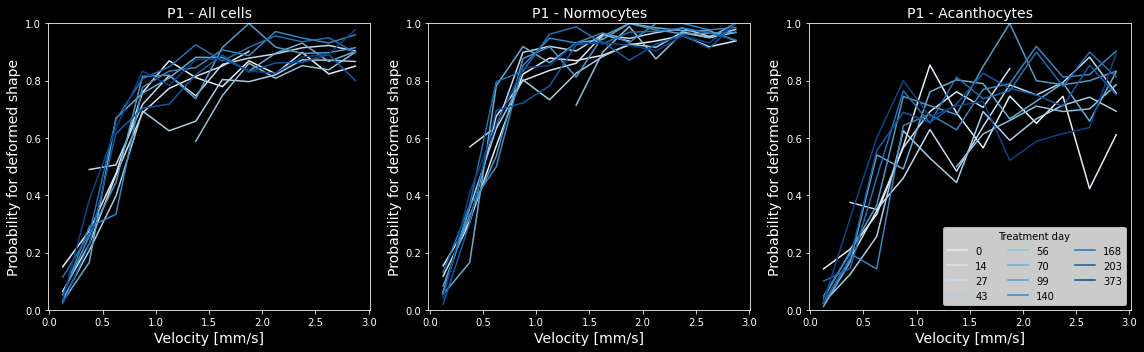

<Figure size 432x288 with 0 Axes>

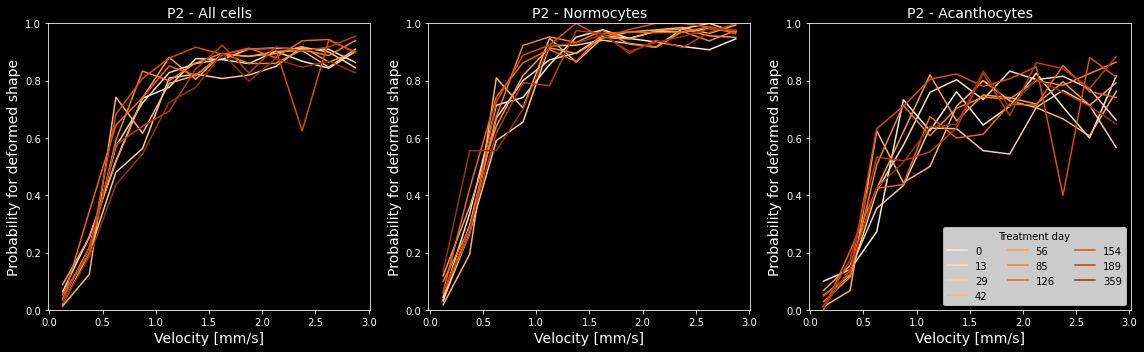

<Figure size 432x288 with 0 Axes>

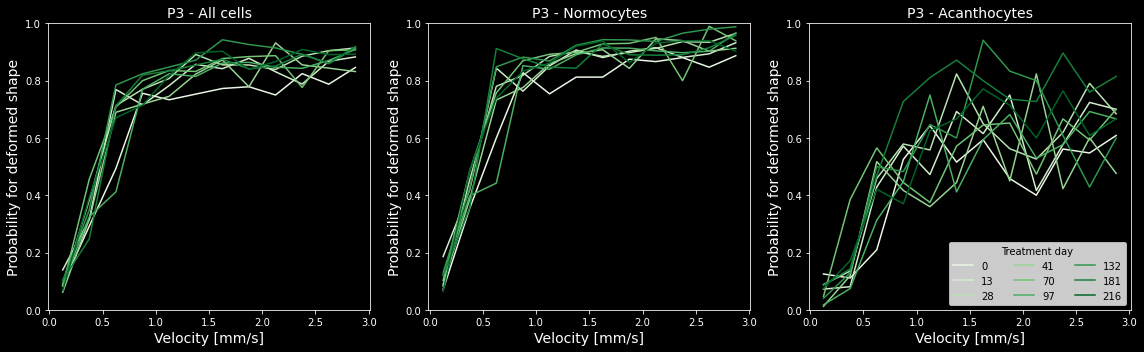

<Figure size 432x288 with 0 Axes>

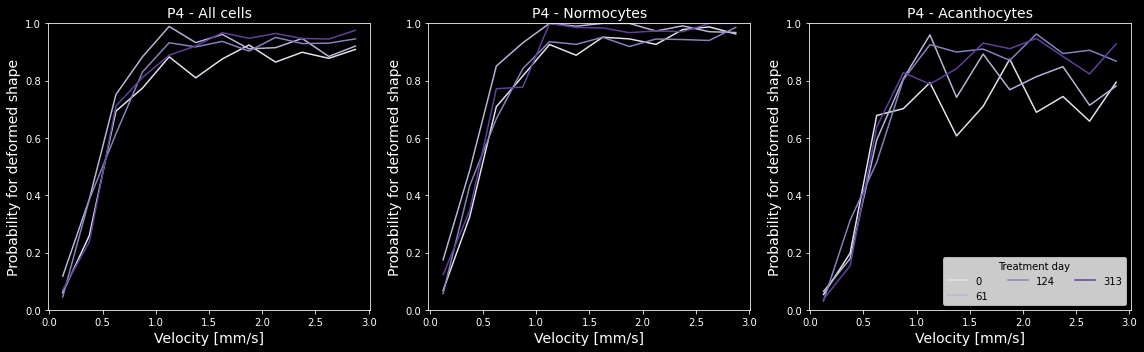

<Figure size 432x288 with 0 Axes>

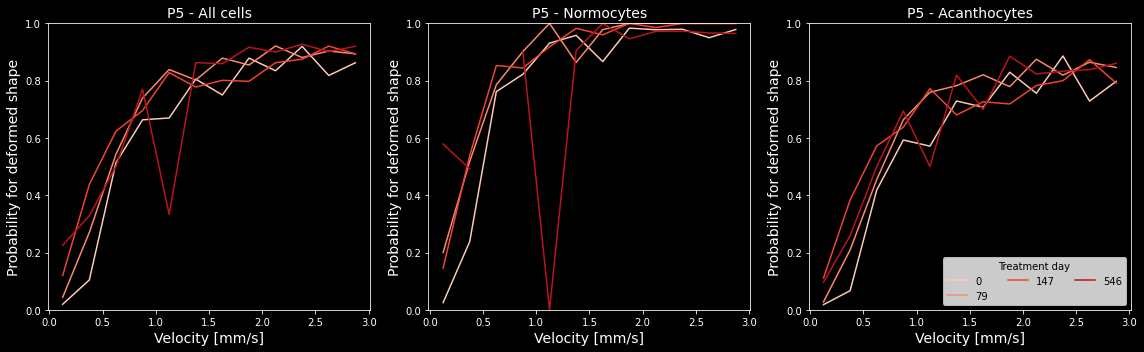

In [5]:
for patient in patient_labels.keys():
    plt.clf()
    fig = plot_all_shape_analysis_curves(patient)
    ax = fig.axes[2]
    ax.legend(ncol=3, title='Treatment day')
    fig.tight_layout()
    savename = "fig_S2_shape_analysis_{}_all_days".format(patient_labels[patient])
    savepath = os.path.join(savefolder,savename)
    fig.savefig(savepath+".pdf", dpi=900, format='pdf')
    plt.show()